# Required import

In [ ]:
%pip install pyriemann_qiskit

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import t

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedGroupKFold
from sklearn.inspection import DecisionBoundaryDisplay

from pyriemann_qiskit.classification import QuanticSVM, QuanticNCH
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_biscatter, plot_bihist, plot_cov_ellipse
from pyriemann.utils import mean_covariance
from pyriemann.spatialfilters import CSP

from pyriemann_qiskit.utils.hyper_params_factory import gen_x_feature_map
from pyriemann_qiskit.visualization.manifold import plot_manifold

from src.utils import load_and_split_subjects_by_group, calculate_covariances_per_subject_and_frame, batch_covs

%load_ext autoreload
%autoreload 2

[QClass]  Initializing Quantum Classifier


/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")


# Extract data

In [4]:
metric="logeuclid"
batch_size = 20

In [5]:

trainval_control_subjects, trainval_parkinson_subjects, test_control_subjects, test_parkinson_subjects, subject_covariances = load_and_split_subjects_by_group(pickle_file_path='data/densetnet201-4-CovsDict.pkl')
trainval_control_covs = calculate_covariances_per_subject_and_frame(subject_covariances = subject_covariances,
                                                               ids = trainval_control_subjects)
trainval_parkinnson_covs = calculate_covariances_per_subject_and_frame(subject_covariances = subject_covariances,
                                                                    ids = trainval_parkinson_subjects)
test_control_covs = calculate_covariances_per_subject_and_frame(subject_covariances = subject_covariances,
                                                            ids = test_control_subjects)
test_parkinson_covs = calculate_covariances_per_subject_and_frame(subject_covariances = subject_covariances,
                                                             ids = test_parkinson_subjects)

In [6]:
c_dataset = trainval_control_covs
c_dataset.extend(test_control_covs)

pk_dataset = trainval_parkinnson_covs
pk_dataset.extend(test_parkinson_covs)

In [7]:
c_dataset_covs, c_dataset_covs_groups = batch_covs(c_dataset, batch_size=batch_size, metric=metric)
c_len = len(c_dataset_covs)
print(f'c_len={c_len}')


pk_dataset_covs, pk_dataset_covs_groups = batch_covs(pk_dataset, batch_size=batch_size, metric=metric)
pk_len = len(pk_dataset_covs)
print(f'pk_len={pk_len}')

X = np.concatenate([c_dataset_covs, pk_dataset_covs], axis=0)
y = np.concatenate([np.zeros(c_len), np.ones(pk_len)])
groups = np.concatenate([c_dataset_covs_groups, pk_dataset_covs_groups])

c_len=736
pk_len=448


# Visualize data

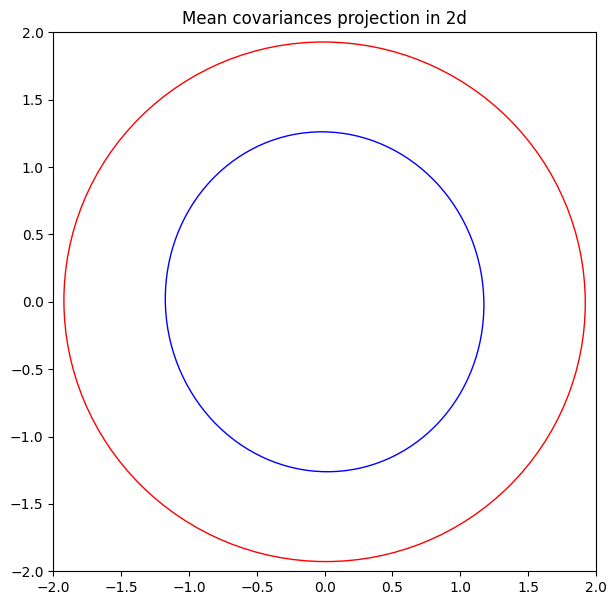

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Mean covariances projection in 2d")
sf = CSP(nfilter=2, log=False)
# sf = PCA_SPD(n_components=2)
X2x2 = sf.fit(X, y).transform(X)
c_meancov = mean_covariance(X2x2[:c_len], metric=metric)
plot_cov_ellipse(ax, c_meancov, edgecolor="blue")
pk_meancov = mean_covariance(X2x2[c_len:], metric=metric)
plot_cov_ellipse(ax, pk_meancov, edgecolor="red")
min_, max_ = -2, 2
ax.set_xlim(min_, max_)
ax.set_ylim(min_, max_)
plt.show()

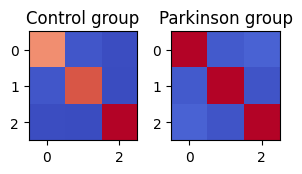

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 1.5, 2 * 1.5))
ax.set_title("Mean covariances 3x3") 
sf = CSP(nfilter=3, log=False)
X3x3 = sf.fit(X, y).transform(X)       
c_meancov = mean_covariance(X3x3[:c_len], metric=metric)
pk_meancov = mean_covariance(X3x3[c_len:], metric=metric)
vmin = min(c_meancov.min(), pk_meancov.min())
vmax = min(c_meancov.max(), pk_meancov.max())
axes[0].imshow(c_meancov, cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[0].set_title("Control group") 
axes[1].imshow(pk_meancov, cmap='coolwarm', vmin=vmin, vmax=vmax)  
axes[1].set_title("Parkinson group") 

plt.tight_layout()
plt.show()

Text(0.5, 0.92, '3d cone of 2x2 covariance matrices')

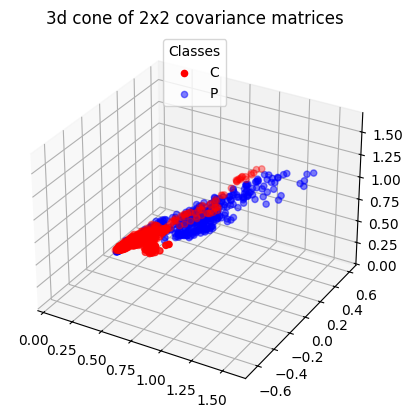

In [12]:
labels = np.array([''] * len(y))
labels[y == 0] = 'Control group'
labels[y == 1] = 'Parkinson group'
fig = plot_manifold(X2x2, labels, False)
fig.axes[0].set_title('3d cone of 2x2 covariance matrices')

# Define pipelines

In [13]:
sf = CSP(nfilter=4, log=False)

pipe_ts_qsvm2 = make_pipeline(
    sf,
    TangentSpace(metric=metric),
    QuanticSVM(gen_feature_map=gen_x_feature_map(reps=2)))
pipe_mdm = make_pipeline(
    sf,
    MDM(metric=metric))
pipe_nch = make_pipeline(
    sf,
    QuanticNCH(
        n_hulls_per_class=1,
        n_samples_per_hull=3,
        n_jobs=12,
        subsampling="random",
        quantum=False,
    )
)
pipe_classical = make_pipeline(
    sf,
    TangentSpace(metric=metric),
    svm.SVC()
)

[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier


# Evaluate

In [14]:
cv = StratifiedGroupKFold(n_splits=10)

In [18]:
scores_svm = cross_val_score(pipe_classical, X, y, scoring="balanced_accuracy", cv=cv, groups=groups)
scores_qsvm = cross_val_score(pipe_ts_qsvm2, X, y, scoring="balanced_accuracy", cv=cv, groups=groups)
print(f'scores svm: {scores_svm.mean()} {scores_svm}')
print(f'scores qsvm: {scores_qsvm.mean()} {scores_qsvm}')
print(f'scores len = {len(scores_svm)}')

                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1024, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1088, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1088, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1024, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1088, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1088, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1088, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1024, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1088, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1056, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...
[QClass]  Prediction finished.
scores svm: 0.8776041666666667 [0.75       0.8125     1.         0.74479167 0.90625    1.
 1.         0.75       0.859375   0.953125  ]
scores qsvm: 0.8828125 [0.74479167 0.90625    1.         0.72395833 0.875      1.
 1.         0.75       0.8515625  0.9765625 ]
scores len = 10


# Corrected t-test

In [21]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [20]:
differences = scores_qsvm - scores_svm
n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])
_, p_value = compute_corrected_ttest(differences, df, n_train, n_test)
print(p_value) # fails to conclude that qsvm has a better performance than svm
# BUT: does not mean it is the same -> we need the bayesian approach or the random testing

0.32179269068318694


# Evaluate difference in predictions

In [15]:
# Let's investigate error in worst split
train_index, test_index = cv.split(X, y, groups).__next__()
X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

In [32]:
# We take a small samples and compare the prediction made by classical/quantum pipeline
y_pred_svc = pipe_classical.fit(X_train, y_train).predict(X_test)
y_pred_qsvc= pipe_ts_qsvm2.fit(X_train, y_train).predict(X_test)
print(balanced_accuracy_score(y_test, y_pred_svc))
print(balanced_accuracy_score(y_test, y_pred_qsvc))

                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1024, 10)
[QClass]  Feature dimension =  10
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  796212
[QClass]  SVM initiating algorithm
[QClass]  Training...
[QClass]  Prediction finished.
0.75
0.7447916666666667


/tmp/ipykernel_12812/1618836778.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['False', '', '', '', '', 'True'])
/tmp/ipykernel_12812/1618836778.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i if i % 2 == 0 else '' for i in range(len(data.index))])


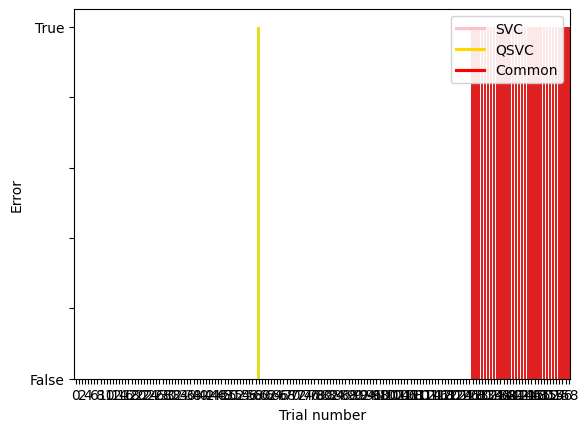

In [33]:
# Display the error made by the two classifier
error_svc = abs(y_test - y_pred_svc)
error_qsvc = abs(y_test - y_pred_qsvc)

error_common = (error_svc == 1) & (error_qsvc == 1)

data = pd.DataFrame({"SVC": error_svc, "QSVC": error_qsvc, "Common": error_common})

sns.barplot(data, x=data.index, y="SVC", color="pink")
sns.barplot(data, x=data.index, y="QSVC", color="yellow")
ax = sns.barplot(data, x=data.index, y="Common", color="red")

# Met en forme la numerotation et le nom des axes
ax.set(xlabel='Trial number', ylabel='Error')
ax.set_yticklabels(['False', '', '', '', '', 'True'])
ax.set_xticklabels([i if i % 2 == 0 else '' for i in range(len(data.index))])

# Legend
plt.legend(title='', loc='upper right', labels=['SVC', 'QSVC', 'Common'], framealpha=0.9)
leg = plt.gca().get_legend()
leg.legend_handles[0].set_color('pink')
leg.legend_handles[1].set_color('#FFD700')
leg.legend_handles[2].set_color('red')

# Separation between classes

In [42]:
# Best split
it = cv.split(X, y, groups)
it.__next__()
it.__next__()
train_index, test_index = it.__next__()
X_train_best, y_train_best = X[train_index], y[train_index]
X_test_best, y_test_best = X[test_index], y[test_index]

In [40]:
def merge_2axes(fig1, fig2, file_name1="f1.png", file_name2="f2.png"):
    fig1.savefig(file_name1)
    fig2.savefig(file_name2)
    plt.close(fig1)
    plt.close(fig2)

    # inherit figures' dimensions, partially
    w1, w2 = [int(np.ceil(fig.get_figwidth())) for fig in (fig1, fig2)]
    hmax = int(np.ceil(max([fig.get_figheight() for fig in (fig1, fig2)])))

    fig, axes = plt.subplots(1, w1 + w2, figsize=(w1 + w2, hmax))

    # make two axes of desired height proportion
    gs = axes[0].get_gridspec()
    for ax in axes.flat:
        ax.remove()
    ax1 = fig.add_subplot(gs[0, :w1])
    ax2 = fig.add_subplot(gs[0, w1:])

    ax1.imshow(plt.imread(file_name1))
    ax2.imshow(plt.imread(file_name2))

    for ax in (ax1, ax2):
        for side in ("top", "left", "bottom", "right"):
            ax.spines[side].set_visible(False)
        ax.tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )

    return fig

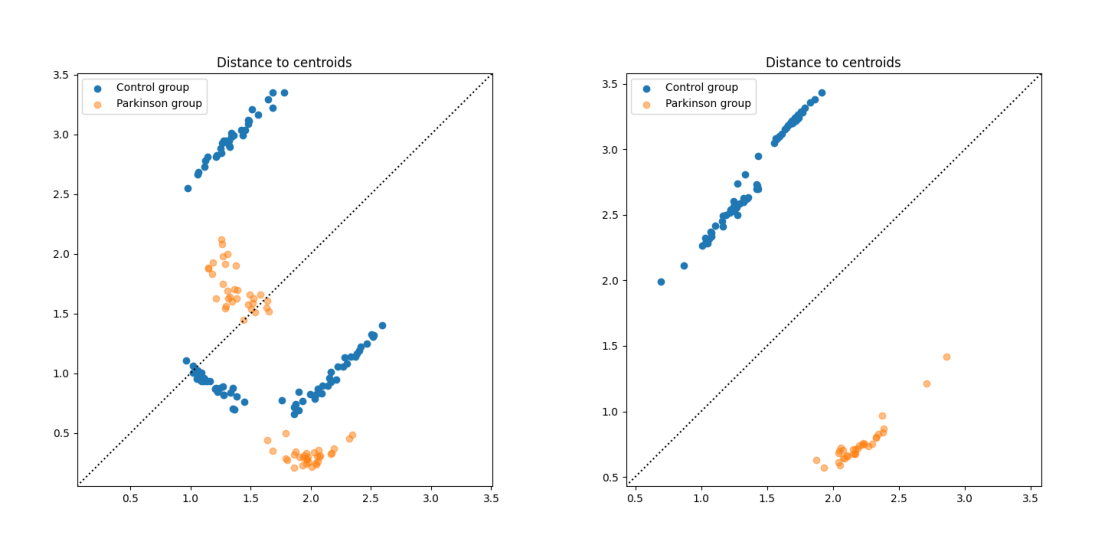

In [48]:
# Use mdm to get the distances between the classes
## best split
dists = pipe_mdm.fit(X_train, y_train).transform(X_test)
fig1 = plot_biscatter(dists, y_test)
fig1.axes[0].set_title('Distance to centroids')
fig1.axes[0].legend(['Control group', 'Parkinson group'])

dists_best = pipe_mdm.fit(X_train_best, y_train_best).transform(X_test_best)
fig2 = plot_biscatter(dists_best, y_test_best)
fig2.axes[0].set_title('Distance to centroids')
fig2.axes[0].legend(['Control group', 'Parkinson group'])

fig = merge_2axes(fig1, fig2)


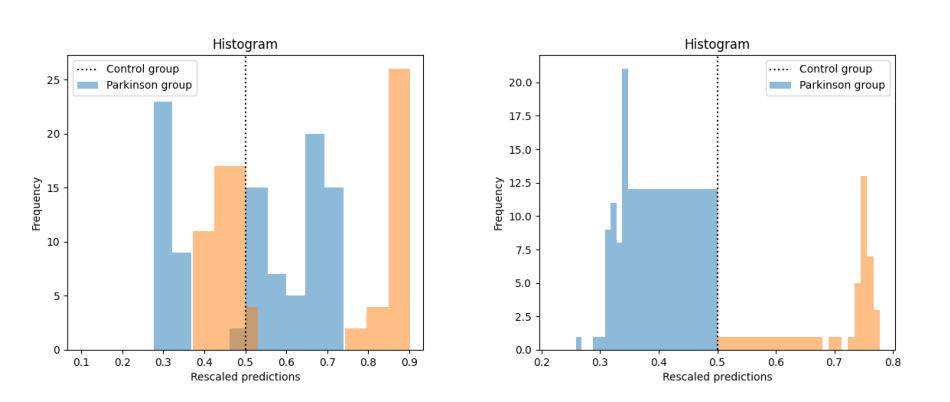

In [51]:
fig1 = plot_bihist(dists, y_test)
fig1.axes[0].legend(['Control group', 'Parkinson group'])
fig2 = plot_bihist(dists_best, y_test_best)
fig2.axes[0].legend(['Control group', 'Parkinson group'])
fig = merge_2axes(fig1, fig2)

## Decision boundary

                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (1024, 2)
[QClass]  Feature dimension =  2
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  350176
[QClass]  SVM initiating algorithm
[QClass]  Training...
[QClass]  Prediction finished.


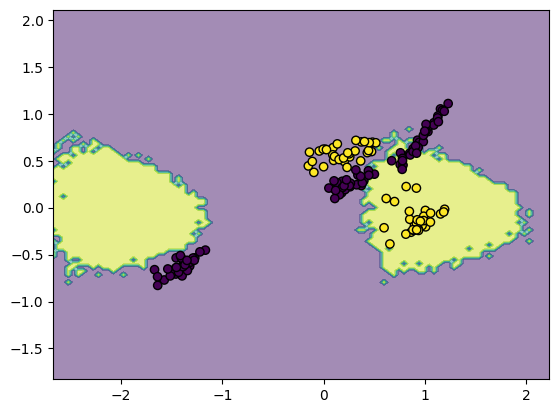

In [47]:
pre_proc = make_pipeline(
    CSP(nfilter=2, log=False),
    TangentSpace(metric=metric),
    PCA(n_components=2),
)
X_test_tr = pre_proc.fit(X_train, y_train).transform(X_test)
X_train_tr = pre_proc.fit(X_train, y_train).transform(X_train)
estimator = QuanticSVM(gen_feature_map=gen_x_feature_map(reps=2))
# estimator = svm.SVC()
estimator.fit(X_train_tr, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    estimator, X_test_tr, response_method="predict",
    # xlabel="xlabel", ylabel="ylabel",
    alpha=0.5,
)
disp.ax_.scatter(X_test_tr[:, 0], X_test_tr[:, 1], c=y_test, edgecolor="k")

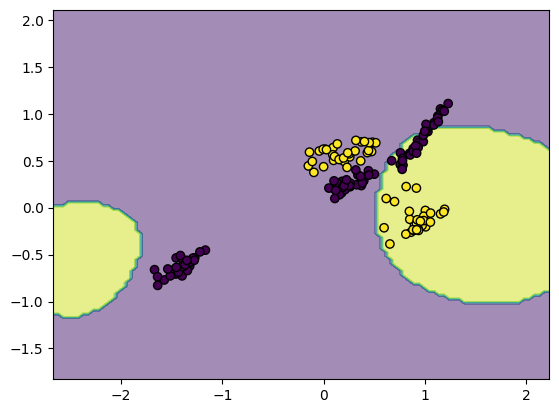

In [48]:
# Decision boundary with classical pipeline
estimator = svm.SVC()
estimator.fit(X_train_tr, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    estimator, X_test_tr, response_method="predict",
    # xlabel="xlabel", ylabel="ylabel",
    alpha=0.5,
)
disp.ax_.scatter(X_test_tr[:, 0], X_test_tr[:, 1], c=y_test, edgecolor="k")

[QClass]  Classical computation will be performed
[QClass]  Fitting:  (118, 4, 4)
[QClass]  Feature dimension =  4
[QClass]  Nearest Convex Hull Classifier initiating algorithm
[QClass]  Using ClassicalOptimizer
[QClass]  Training...


/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample w

[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier


/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample will fail.
  warn("mne not available. get_mne_sample will fail.")
/home/codespace/.python/current/lib/python3.12/site-packages/pyriemann_qiskit/datasets/utils.py:11: UserWarning: mne not available. get_mne_sample w

[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier


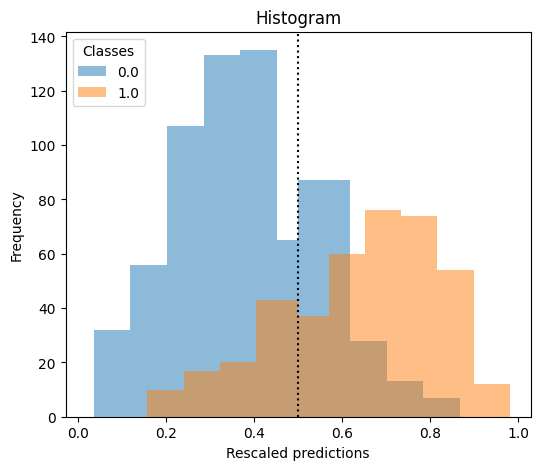

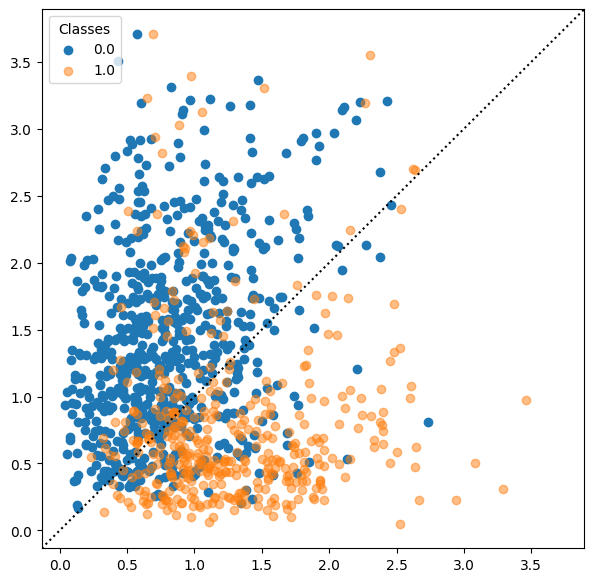

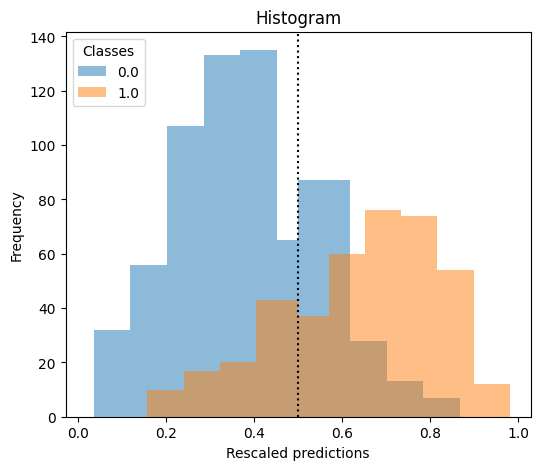

In [41]:
# Use NCH to get the distances between the classes (distance to convex hull)
dists = pipe_nch.fit(X_train, y_train).transform(X_test)
plot_biscatter(dists, y_test)
plot_bihist(dists, y_test)